In [1]:
import numpy as np
import pandas as pd
import copy #Use for Deep copy

import seaborn as sns
import matplotlib.pyplot as plt

# Open the response matrix saved previously

In [2]:
with open('D:\\decertation\\data\\Fact evolution dataset\\new code\\response_matrix.npy', 'rb') as f:
    response_matrix1 = np.load(f)
print(response_matrix1)

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [3]:
response_matrix = copy.deepcopy(response_matrix1)
response_matrix[response_matrix == 2] = -1

# Open the gold result

In [4]:
train = pd.read_csv('D:\\decertation\\data\\Fact evolution dataset\\new code\\new_gold_without_skip.csv')
print(train.head())

   Unnamed: 0  Question_id  Question_Reduced_Id  Gold_level
0           0        23647                23646           1
1           1        10756                10755           1
2           2        40638                40637           1
3           3        22855                22854           1
4           4        13988                13987           1


# No of 0 and 1 in data set

In [5]:
judgement_counts = np.bincount(train['Gold_level'])
Negetive = judgement_counts[0]
Positive = judgement_counts[1]        
print(f'Positive : {Positive}, Negetive : {Negetive}')

Positive : 531, Negetive : 19


In [6]:
c, r = len(np.unique(response_matrix))-1, response_matrix.shape[1]
p = r * c

In [7]:
tot_ques = r
print(f'Total question : {tot_ques}')

Total question : 42624


# Work with response matrix

# Calculating accuracy of annotators using train set

In [8]:
s1 = int(len(train)* 0.3)
train2 = train[:s1]

In [9]:
s1 = int(len(train)* 0.3)
train2 = train[ : s1]

accuracy = [1 / len(train2)]*response_matrix.shape[0]
for i in range (response_matrix.shape[0]):
    tot, corr = 0.0, 0.0
    for j in range(len(train2)):
        if -1 != response_matrix[i][train2[train2.columns[2]][j]]:
            tot += 1
            if train2[train2.columns[3]][j] == response_matrix[i][train2[train2.columns[2]][j]]:
                corr += 1
    if tot != 0:
        accuracy[i] += corr / tot
minacc = np.min(accuracy)
maxacc = np.max(accuracy)
accuracy = (accuracy - minacc)/ (maxacc-minacc)
print(accuracy[ : 5])

[0.         1.         1.         0.95652174 1.        ]


# Required Functions

In [10]:
def dist(a,b):
    s = 0
    for j in range(len(a)):
        if a[j] != b[j]:
            s += 1
    return s

In [11]:
def local_directory(row):
    local_dict = {
        'vector': row,
        'frequency': 1,
        'response_number': np.count_nonzero(row != -1)
    }
    return local_dict

In [12]:
#Cluster with distance = hyp
def cluster(cluster_dict, block, hyp):
    cluster_id = []
    distance, i = 0, len(cluster_dict)
    for j in range(len(block)):
        if len(cluster_dict) == 0:
            i += 1
            cluster_dict[i] = local_directory(block[j])
            cluster_id.append(i)

        else:
            l, k = 1, i
            while l <= k:
                d = dist(block[j], cluster_dict[l]['vector'])
                if d <= hyp:
                    cluster_dict[l]['frequency'] += 1
                    cluster_id.append(l)
                    distance += d
                    break
                else:
                    l += 1

                if l == k+1:
                    i += 1
                    cluster_dict[i] = local_directory(block[j])
                    cluster_id.append(i)

    return cluster_dict, cluster_id, distance


In [13]:
#Clustering with finding the distance
def clustering(cluster_dict, block, d):
    # Use ELBOW Method to find the threshold of the distance
    distance_list = []
    
    for it in range (1,100):
        k = it * 100
        cluster_dictionary = copy.deepcopy(cluster_dict)
        _, _, distance = cluster(cluster_dictionary, block, k)
        distance_list.append(distance)
        
    ratio = [(distance_list[i] - distance_list[i-1]) * 0.001 for i in range(1, len(distance_list))]
    ratio1 = [a for a in ratio if a != 0]
    index = [i for i, a in enumerate(ratio) if a != 0]

    ind_ch = [(ratio1[i] - ratio1[i-1]) / (index[i] - index[i-1]) for i in range(1, len(index))]

    dis = d
    index = next((i for i, val in enumerate(ind_ch[1:], start=1) if val >= 1), None)
    if index is not None:
        a = ind_ch.index(ind_ch[index]) + 1
        dis = ratio.index(ratio1[a]) * 100
                
#     cluster_dict,cluster_id, _ = cluster(cluster_dict, block, dis)   
    return cluster_dict, dis

In [14]:
def judge(J, block, cluster_dict, a, dis):    
    cluster_dict, cluster_id, dis = cluster(cluster_dict, block, dis)
    weight = []

    for k in range(block.shape[0]):
        w = accuracy[a + k] + const * cluster_dict[cluster_id[k]]['response_number']/cluster_dict[cluster_id[k]]['frequency']
        weight.append(w)
    
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if block[k][j] != -1:
                J[j][block[k][j]] += weight[k]
    return J, cluster_dict

# main function

In [15]:
const = 0.001
dis = 1000
cluster_dict = {}
J = np.array([0.]*p).reshape(r, c)
Result = np.array([-1]*r)

In [16]:
a, b = 0, 19

A = response_matrix[a : b]
_, dis = clustering(cluster_dict, A, dis)


# step = 1
while b <= response_matrix.shape[0]:
#     print(f'step = {step}')
#     step += 1
    A = response_matrix[a : b]
    J, cluster_dict = judge(J, A, cluster_dict, a, dis)
    
    # Calculate final result
    Result = np.argmax(J, axis=1)
    
    #Calculate accuracy
    right = np.sum(train[train.columns[3]].values == Result[train[train.columns[2]].values])
           
    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 19

Accuracy after 19 annotators' response is 87.8182 %
Accuracy after 38 annotators' response is 95.4545 %
Accuracy after 57 annotators' response is 94.3636 %


# Confusion matrix

In [17]:
Conf = np.zeros((2,2), dtype = 'int64')

In [18]:
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Conf[0][0] += 1
        else:
            Conf[1][0] += 1
    if train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Conf[1][1] += 1
        else:
            Conf[0][1] += 1
print(Conf)

[[500   0]
 [ 31  19]]


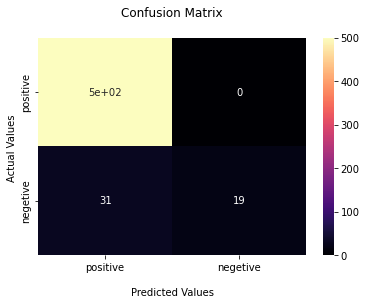

In [19]:
ax = sns.heatmap(Conf, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('positive', 'negetive'))
ax.yaxis.set_ticklabels(i for i in ('positive', 'negetive'))
plt.show()

# Majority voting

In [20]:
def majority(J, block, a):
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if response_matrix[a + k][j] != -1:
                J[j][response_matrix[a + k][j]] += 1  
        
    return J

Main function for Majority voting

In [21]:
a, b = 0, 19

M = np.array([-1]*p).reshape(r, c)
Majority_Result = np.array([-1]*r)

while b <= response_matrix.shape[0]:
    A = response_matrix[a : b]
    M = majority(M, A, a)
    
    Majority_Result = np.argmax(M, axis=1)
    
    right = np.sum(train[train.columns[3]].values == Majority_Result[train[train.columns[2]].values])

    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 19

Accuracy after 19 annotators' response is 86.7273 %
Accuracy after 38 annotators' response is 94.5455 %
Accuracy after 57 annotators' response is 94.3636 %


Confusion matrix

In [22]:
Confusion_matrix = np.zeros((2, 2), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[0][1] += 1
            
    elif train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[1][0] += 1
print(Confusion_matrix)

[[500  31]
 [  0  19]]


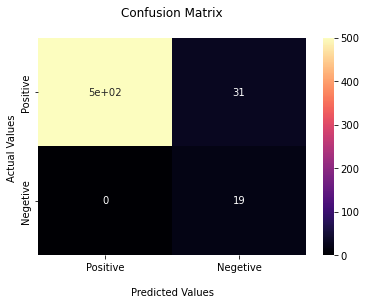

In [23]:
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Positive', 'Negetive'))
ax.yaxis.set_ticklabels(i for i in ('Positive', 'Negetive'))
plt.show()

# Report of Crowdscale Shared Task Challenge 2013 by Liu, Peng, Ihler(Without Streaming)

This algorithm is effective only for Fact evolution dataset

In [24]:
result = [-1]*(response_matrix.shape[1])

for j in range(response_matrix.shape[1]):
    a, b, ans = 0, 0, 0
    for i in range(response_matrix.shape[0]):
        if response_matrix[i][j] == 0:
            a += 1
            ans += 1
        elif response_matrix[i][j] == 1:
            b += 1
            ans += 1
            
    if (a / ans > 0.8):
        result[j] = 0
    elif (b / ans > 0.4):
        result[j] = 1

In [25]:
right = 0
for j in range(len(train)):
    if train[train.columns[3]][j] != 2:
        if train[train.columns[3]][j] == result[train[train.columns[2]][j]]:
            right += 1
print(f'Accuracy after {response_matrix.shape[0]} annotators\' response is {right / len(train) * 100 :.4f} %')

Accuracy after 57 annotators' response is 94.1818 %


In [26]:
Confusion_matrix = np.zeros((2, 2), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[0][1] += 1
    elif train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[1][0] += 1
print(Confusion_matrix)

[[501   4]
 [  0  17]]


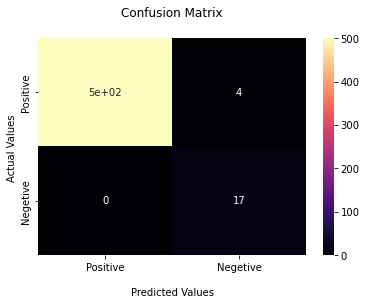

In [27]:
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Positive', 'Negetive'))
ax.yaxis.set_ticklabels(i for i in ('Positive', 'Negetive'))
plt.show()

# Weighted Majority Voting

In [28]:
def weighted_majority(J, block, a):
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if response_matrix[a + k][j] != -1:
                J[j][response_matrix[a + k][j]] += accuracy[a + k]
        
    return J

In [29]:
a, b = 0, 19

M = np.array([-1.]*p).reshape(r, c)
Weighted_Majority_Result = np.array([-1]*r)

while b <= response_matrix.shape[0]:
    A = response_matrix[a : b]
    M = weighted_majority(M, A, a)
    
    Weighted_Majority_Result = np.argmax(M, axis=1)
    
    right = np.sum(train[train.columns[3]].values == Weighted_Majority_Result[train[train.columns[2]].values])

    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 19

Accuracy after 19 annotators' response is 88.5455 %
Accuracy after 38 annotators' response is 96.0000 %
Accuracy after 57 annotators' response is 94.3636 %


In [30]:
Confusion_matrix = np.zeros((2, 2), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[0][1] += 1
            
    elif train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[1][0] += 1
print(Confusion_matrix)

[[500  31]
 [  0  19]]


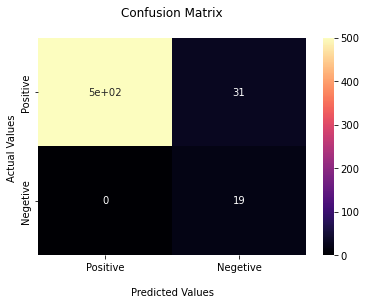

In [31]:
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Positive', 'Negetive'))
ax.yaxis.set_ticklabels(i for i in ('Positive', 'Negetive'))
plt.show()